## Imports, Settings, & Functions

In [3]:
import cv2
import PIL.Image as Image
import os
import shutil
from scipy.io import loadmat
from scipy.io.matlab import mat_struct
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import json
from tqdm import tqdm
from collections import defaultdict
import pickle
import torch
import matplotlib.pyplot as plt

from data.dataset import ImageWaveformDataset


In [4]:
def print_object_structure(obj, depth=0, max_depth=None, name="root"):
    spacer = "  " * depth

    # Stop recursion and do NOT print anything if max_depth reached
    if max_depth is not None and depth >= max_depth:
        return

    if isinstance(obj, dict):
        print(f"{spacer}{name}: dict, len={len(obj)}")
        for key, value in obj.items():
            print_object_structure(value, depth + 1, max_depth, name=repr(key))

    elif isinstance(obj, list):
        print(f"{spacer}{name}: list, len={len(obj)}")
        for idx, item in enumerate(obj):
            print_object_structure(item, depth + 1, max_depth, name=f"[{idx}]")

    elif isinstance(obj, np.ndarray):
        print(f"{spacer}{name}: ndarray, shape={obj.shape}")

    else:
        print(f"{spacer}{name}: {type(obj).__name__}")



In [6]:
# To Load the Preprocessed Training Waveforms
with open("data/collected_stimulus_waveforms.pkl", "rb") as f:
    collected_stimulus_waveforms_from_all_electrodes_l = pickle.load(f)

In [7]:
# To Load the Preprocessed Training Waveforms
with open("data/image_paths_dict.pkl", "rb") as f:
    image_paths_dict = pickle.load(f)

In [ ]:
# print_object_structure(image_paths_dict, max_depth=3)

root: dict, len=120
  'condition_000': dict, len=16
    'electrode_00': list, len=192
    'electrode_01': list, len=83
    'electrode_02': list, len=460
    'electrode_03': list, len=16
    'electrode_04': list, len=355
    'electrode_05': list, len=32
    'electrode_06': list, len=189
    'electrode_07': list, len=47
    'electrode_08': list, len=53
    'electrode_09': list, len=159
    'electrode_10': list, len=54
    'electrode_11': list, len=190
    'electrode_12': list, len=27
    'electrode_13': list, len=87
    'electrode_14': list, len=149
    'electrode_15': list, len=200
  'condition_001': dict, len=16
    'electrode_00': list, len=174
    'electrode_01': list, len=101
    'electrode_02': list, len=437
    'electrode_03': list, len=129
    'electrode_04': list, len=358
    'electrode_05': list, len=22
    'electrode_06': list, len=213
    'electrode_07': list, len=48
    'electrode_08': list, len=87
    'electrode_09': list, len=193
    'electrode_10': list, len=128
    'elec

In [ ]:
# # Loading Image Paths Only

# # Define root directory
# root_dir = "data/stimulus_images/"

# # Initialize nested dictionary
# image_paths_dict = {}

# # Traverse the root directory
# for collection in sorted(os.listdir(root_dir)):
#     collection_path = os.path.join(root_dir, collection)
#     if os.path.isdir(collection_path):
#         image_paths_dict[collection] = {}

#         for electrode in sorted(os.listdir(collection_path)):
#             electrode_path = os.path.join(collection_path, electrode)
#             if os.path.isdir(electrode_path):
#                 image_list = []
#                 for filename in sorted(os.listdir(electrode_path)):
#                     if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
#                         image_path = os.path.join(electrode_path, filename)
#                         image_list.append(image_path)  # Just append the path
#                 image_paths_dict[collection][electrode] = image_list


In [ ]:
print_object_structure(collected_stimulus_waveforms_from_all_electrodes_l, max_depth=3)

root: list, len=120
  [0]: list, len=16
    [0]: ndarray, shape=(192, 16, 48)
    [1]: ndarray, shape=(83, 16, 48)
    [2]: ndarray, shape=(460, 16, 48)
    [3]: ndarray, shape=(16, 16, 48)
    [4]: ndarray, shape=(355, 16, 48)
    [5]: ndarray, shape=(32, 16, 48)
    [6]: ndarray, shape=(189, 16, 48)
    [7]: ndarray, shape=(47, 16, 48)
    [8]: ndarray, shape=(53, 16, 48)
    [9]: ndarray, shape=(159, 16, 48)
    [10]: ndarray, shape=(54, 16, 48)
    [11]: ndarray, shape=(190, 16, 48)
    [12]: ndarray, shape=(27, 16, 48)
    [13]: ndarray, shape=(87, 16, 48)
    [14]: ndarray, shape=(149, 16, 48)
    [15]: ndarray, shape=(200, 16, 48)
  [1]: list, len=16
    [0]: ndarray, shape=(174, 16, 48)
    [1]: ndarray, shape=(101, 16, 48)
    [2]: ndarray, shape=(437, 16, 48)
    [3]: ndarray, shape=(129, 16, 48)
    [4]: ndarray, shape=(358, 16, 48)
    [5]: ndarray, shape=(22, 16, 48)
    [6]: ndarray, shape=(213, 16, 48)
    [7]: ndarray, shape=(48, 16, 48)
    [8]: ndarray, shape=(87, 16,

In [ ]:
print_object_structure(image_paths_dict, max_depth=3)

root: dict, len=120
  'condition_000': dict, len=16
    'electrode_00': list, len=192
    'electrode_01': list, len=83
    'electrode_02': list, len=460
    'electrode_03': list, len=16
    'electrode_04': list, len=355
    'electrode_05': list, len=32
    'electrode_06': list, len=189
    'electrode_07': list, len=47
    'electrode_08': list, len=53
    'electrode_09': list, len=159
    'electrode_10': list, len=54
    'electrode_11': list, len=190
    'electrode_12': list, len=27
    'electrode_13': list, len=87
    'electrode_14': list, len=149
    'electrode_15': list, len=200
  'condition_001': dict, len=16
    'electrode_00': list, len=174
    'electrode_01': list, len=101
    'electrode_02': list, len=437
    'electrode_03': list, len=129
    'electrode_04': list, len=358
    'electrode_05': list, len=22
    'electrode_06': list, len=213
    'electrode_07': list, len=48
    'electrode_08': list, len=87
    'electrode_09': list, len=193
    'electrode_10': list, len=128
    'elec

In [9]:
dataset = ImageWaveformDataset(waveform_dict = collected_stimulus_waveforms_from_all_electrodes_l, 
                     image_paths_dict=image_paths_dict, 
                     transform=None
                     )

In [10]:
print_object_structure(dataset.samples, max_depth=1)

root: list, len=413160


In [15]:
img = Image.open(dataset.samples[0][1])

In [18]:
img.size

(320, 240)

## Visualizing the Response Waveform and the Stimulus Image

In [229]:
idx = 0

idx: 36310


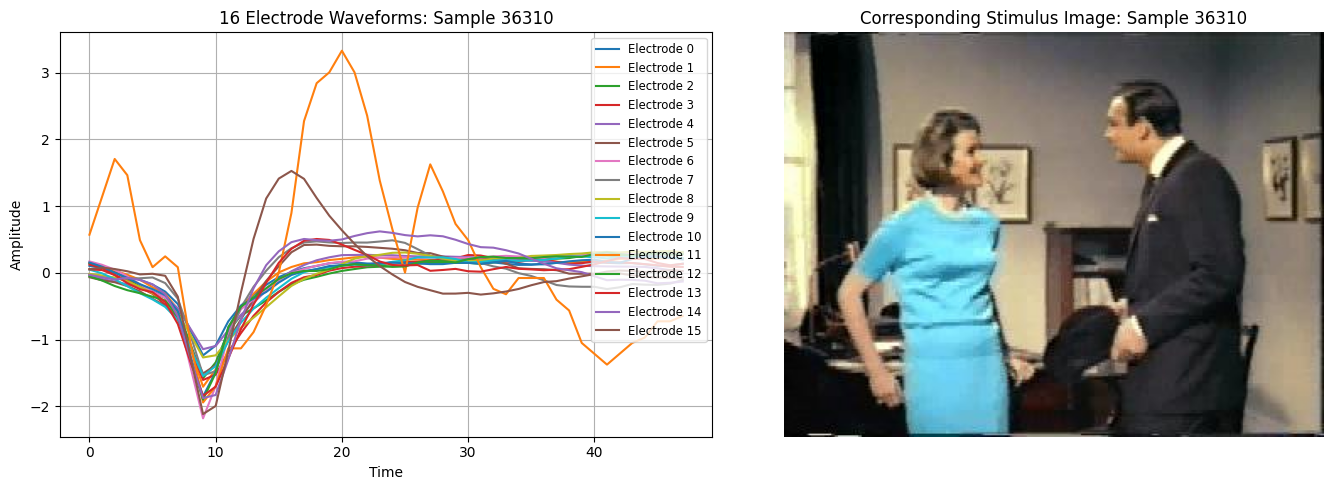

In [ ]:
# Increment index
idx += 100

print(f"idx: {idx}")

# Get waveform data: shape (16, 48)
waveforms = dataset.samples[idx][0]

# Get image path and load image
image_path = dataset.samples[idx][1]
img = Image.open(image_path)

# Create figure with 1 row, 2 columns
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# ---- Left: 16 Waveforms ----
time = np.arange(48)
for i in range(16):
    axs[0].plot(time, waveforms[i], label=f'Electrode {i}')

axs[0].set_title(f'16 Electrode Waveforms: Sample {idx}')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Amplitude')
axs[0].legend(fontsize='small', loc='upper right')
axs[0].grid(True)

# ---- Right: Image ----
axs[1].imshow(img)
axs[1].axis('off')
axs[1].set_title(f'Corresponding Stimulus Image: Sample {idx}')

# Tight layout and show
plt.tight_layout()
plt.show()


In [17]:
import numpy as np

total = 0
for cond in collected_stimulus_waveforms_from_all_electrodes_l:
    for arr in cond:
        total += arr.nbytes

print(f"Total NumPy memory: {total / 1e6:.2f} MB")


Total NumPy memory: 2538.46 MB


In [ ]:
print_object_structure()

In [ ]:
# import pickle# Define output file path
# output_path = "data/image_paths_dict.pkl"
# # Save (pickle) the object
# with open(output_path, "wb") as f:
#     pickle.dump(image_paths_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

# print(f"Object pickled successfully to {output_path}")


Object pickled successfully to data/image_paths_dict.pkl
